In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.initializers import Constant, RandomNormal, he_uniform
from keras import backend as K

from geopy import distance

## Dados

In [3]:
seed = 301021
data = pd.read_csv("lorawan_dataset_antwerp.csv")
data.head()

,'BS 1','BS 2','BS 3','BS 4','BS 5','BS 6','BS 7','BS 8','BS 9','BS 10',...,'BS 64','BS 65','BS 66','BS 67','BS 68','RX Time','SF','HDOP','Latitude','Longitude'
0,-200,-200,-200,-200,-200,-200,-200,-200,-114,-200,...,-200,-200,-200,-200,-200,'2017-12-28T16:14:07.247000+00:00',12,1.02,51.216736,4.412130
1,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,'2017-11-28T12:01:02.380000+00:00',7,0.57,51.232037,4.405185
2,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,'2017-12-14T09:05:22.832000+00:00',9,1.00,51.202763,4.390477
3,-200,-100,-200,-200,-200,-200,-200,-200,-200,-113,...,-200,-200,-200,-200,-200,'2018-01-17T09:11:49.222000+00:00',12,0.62,51.194584,4.417887
4,-200,-106,-107,-200,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,'2018-01-10T14:47:01.379000+00:00',12,1.00,51.207203,4.403470


In [4]:
data_1 = data.copy().drop(["'RX Time'", "'SF'", "'HDOP'"], axis=1)
data_1.head()

,'BS 1','BS 2','BS 3','BS 4','BS 5','BS 6','BS 7','BS 8','BS 9','BS 10',...,'BS 61','BS 62','BS 63','BS 64','BS 65','BS 66','BS 67','BS 68','Latitude','Longitude'
0,-200,-200,-200,-200,-200,-200,-200,-200,-114,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,51.216736,4.412130
1,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,51.232037,4.405185
2,-200,-200,-200,-200,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,51.202763,4.390477
3,-200,-100,-200,-200,-200,-200,-200,-200,-200,-113,...,-200,-200,-200,-200,-200,-200,-200,-200,51.194584,4.417887
4,-200,-106,-107,-200,-200,-200,-200,-200,-200,-200,...,-200,-200,-200,-200,-200,-200,-200,-200,51.207203,4.403470


In [5]:
X = data_1.copy().drop(["'Latitude'", "'Longitude'"], axis=1)
y = data_1[["'Latitude'", "'Longitude'"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)

## Pré-processamentos

In [6]:
def exponential(x):
  return np.exp(x/(-200))/np.exp((-200)*(-1)/24)

def powed(x):
#  return (x**np.e)/((min_value * (-1))**np.e)
  return ((x+200)**np.e)/(((-200) * (-1))**np.e)

def exponentialConverter(df):
  return df.apply(exponential)

def powedConverter(df):
  return df.apply(powed)

def getMeanDistance(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred)
    temp = y_true.copy()
    temp.reset_index(drop=True, inplace=True)
    temp = temp.rename(columns={"'Latitude'": 0, "'Longitude'": 1})
    d = []
    for i in range(len(y_true)):
        d1 = (temp[0][i], temp[1][i])
        d2 = (y_pred[0][i], y_pred[1][i])
        d.append(distance.distance(d1, d2).m)

    return sum(d)/len(d)

In [7]:
pca_transformer1 = pca_transformer2 = pca_transformer3 = PCA(n_components=40)
ss_transformer = StandardScaler()

X_p = X.copy()
X_p[X_p == -200] = 0

X_s = ss_transformer.fit_transform(X)
X_e = exponentialConverter(X)
X_p = powedConverter(X_p)

# dados na forma linear(normalizados)
X_train_linear = ss_transformer.fit_transform(X_train)
X_dev_linear = ss_transformer.fit_transform(X_dev)
X_test_linear = ss_transformer.fit_transform(X_test)

# dados positivos
X_train_p = X_train.copy()
X_dev_p = X_dev.copy()
X_test_p = X_test.copy()
X_train_p[X_train_p == -200] = 0
X_dev_p[X_dev_p == -200] = 0
X_test_p[X_test_p == -200] = 0

# dados na forma exponencial e na forma potencial
X_train_exp = exponentialConverter(X_train)
X_dev_exp = exponentialConverter(X_dev)
X_test_exp = exponentialConverter(X_test)
X_train_powed = powedConverter(X_train_p)
X_dev_powed = powedConverter(X_dev_p)
X_test_powed = powedConverter(X_test_p)

# aplicação do PCA aos dados
pca_transformer1.fit(X_s)
pca_transformer2.fit(X_e)
pca_transformer3.fit(X_p)

X_train_linear = pca_transformer1.transform(X_train_linear)
X_dev_linear = pca_transformer1.transform(X_dev_linear)
X_test_linear = pca_transformer1.transform(X_test_linear)
X_train_exp = pca_transformer2.transform(X_train_exp)
X_dev_exp = pca_transformer2.transform(X_dev_exp)
X_test_exp = pca_transformer2.transform(X_test_exp)
X_train_powed = pca_transformer3.transform(X_train_powed)
X_dev_powed = pca_transformer3.transform(X_dev_powed)
X_test_powed = pca_transformer3.transform(X_test_powed)

C:\Users\pedro\miniconda3\envs\icenv2\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
C:\Users\pedro\miniconda3\envs\icenv2\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
C:\Users\pedro\miniconda3\envs\icenv2\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


## Configuração de ambiente

In [8]:
os.environ['PYTHONHASHSEED']=str(seed)

random.seed(seed)

np.random.seed(seed)

tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

## Redes Neurais treinadas com dados na forma linear

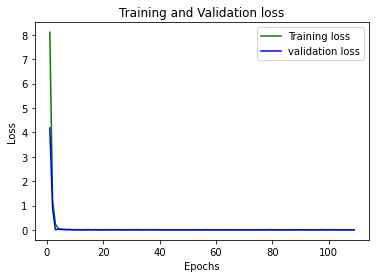

R² (train):  0.5935192321454579
R² (dev): 0.6045912052310486
Mean Distance (train): 1099.434540615014
Mean Distance (dev): 1080.67019691234


In [10]:
n_inputs, n_outputs = X_train_linear.shape[1], y_train.shape[1]
epochs = 109

def evaluate_model():
    results = list()
    history = model.fit(X_train_linear, y_train, verbose=0, epochs=epochs, batch_size=100, validation_data=(X_dev_linear, y_dev))
    result = model.evaluate(X_dev_linear, y_dev, verbose=0)
    results.append(result)
    return results,history

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))   

rmse = tf.keras.metrics.RootMeanSquaredError()
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

model = Sequential()
model.add(Dense(14, input_dim=n_inputs,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.add(Dense(10, input_dim=n_inputs,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, input_dim=n_inputs,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.add(Dense(8, input_dim=n_inputs,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.add(Dense(5, input_dim=n_inputs,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.add(Dense(n_outputs, kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.compile(loss=root_mean_squared_error, optimizer=adam, metrics=[rmse])

#model = Sequential()
#model.add(Dense(5, input_dim=n_inputs,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
#model.add(Dense(9,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(12,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(9,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
#model.add(Dense(5,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
#model.add(Dense(n_outputs, kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
#model.compile(loss=root_mean_squared_error, optimizer=adam, metrics=[rmse])

def getPerformance():
    results, history = evaluate_model() 
    y_pred1 = model.predict(X_train_linear)
    y_pred2 = model.predict(X_dev_linear)
    r2 = r2_score(y_train, y_pred1)
    r22 = r2_score(y_dev, y_pred2) 
    md1 = getMeanDistance(y_train, y_pred1)
    md2 = getMeanDistance(y_dev, y_pred2) 
    return [r2, r22, md1, md2, results, history]

response = getPerformance()
history = response[-1]
results = response[4]

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


print("R² (train): ", response[0])
print("R² (dev):", response[1])
print("Mean Distance (train):", response[2]) 
print("Mean Distance (dev):", response[3]) 

## Redes Neurais treinadas com dados na forma exponencial

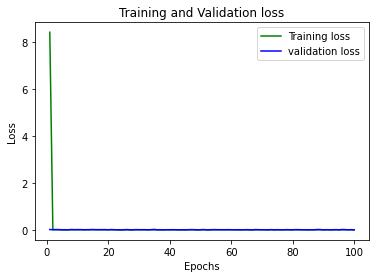

R² (train):  -0.48670494999038716
R² (dev): -0.47434871513148935
Mean Distance (train): 1931.9730886335597
Mean Distance (dev): 1916.8556744722941


In [11]:
n_inputs, n_outputs = X_train_exp.shape[1], y_train.shape[1]

def evaluate_model():
    results = list()
    history = model.fit(X_train_exp, y_train, verbose=0, epochs=100, batch_size=100, validation_data=(X_dev_exp, y_dev))
    result = model.evaluate(X_dev_exp, y_dev, verbose=0)
    results.append(result)
    return results,history

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))   

rmse = tf.keras.metrics.RootMeanSquaredError()
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

model = Sequential()
model.add(Dense(10, input_dim=n_inputs,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.add(Dense(9, input_dim=n_inputs,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.add(Dense(9, input_dim=n_inputs,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.add(Dense(7, input_dim=n_inputs,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.add(Dense(3, input_dim=n_inputs,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.add(Dense(n_outputs, kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.compile(loss=root_mean_squared_error, optimizer=adam, metrics=[rmse])

def getPerformance():
    results, history = evaluate_model() 
    y_pred1 = model.predict(X_train_exp)
    y_pred2 = model.predict(X_dev_exp)
    r2 = r2_score(y_train, y_pred1)
    r22 = r2_score(y_dev, y_pred2) 
    md1 = getMeanDistance(y_train, y_pred1)
    md2 = getMeanDistance(y_dev, y_pred2) 
    return [r2, r22, md1, md2, results, history]

response = getPerformance()
history = response[-1]
results = response[4]

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


print("R² (train): ", response[0])
print("R² (dev):", response[1]) # -0.1408108217110577
print("Mean Distance (train):", response[2]) 
print("Mean Distance (dev):", response[3]) # 1701.006463035978

## Redes Neurais treinadas com dados na forma potencial

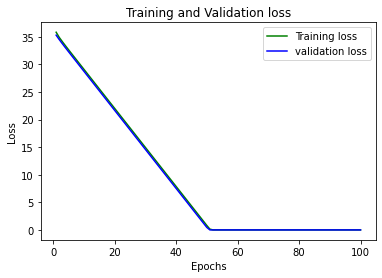

R² (train):  -0.004550791016052269
R² (dev): -0.002982413525180916
Mean Distance (train): 1629.1419508593767
Mean Distance (dev): 1626.2224614101867


In [12]:
n_inputs, n_outputs = X_train_powed.shape[1], y_train.shape[1]

def evaluate_model():
    results = list()
    history = model.fit(X_train_powed, y_train, verbose=0, epochs=100, batch_size=100, validation_data=(X_dev_exp, y_dev))
    result = model.evaluate(X_dev_powed, y_dev, verbose=0)
    results.append(result)
    return results,history

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))   

rmse = tf.keras.metrics.RootMeanSquaredError()
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

model = Sequential()
model.add(Dense(10-2, input_dim=n_inputs,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.add(Dense(9, input_dim=n_inputs,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(9, input_dim=n_inputs,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.add(Dense(7, input_dim=n_inputs,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.add(Dense(3, input_dim=n_inputs,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.add(Dense(1, input_dim=n_inputs,kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.add(Dense(n_outputs, kernel_initializer=he_uniform(seed=seed), bias_initializer=Constant(value=0.1), activation='relu'))
model.compile(loss=root_mean_squared_error, optimizer=adam, metrics=[rmse])

def getPerformance():
    results, history = evaluate_model() 
    y_pred1 = model.predict(X_train_powed)
    y_pred2 = model.predict(X_dev_powed)
    r2 = r2_score(y_train, y_pred1)
    r22 = r2_score(y_dev, y_pred2) 
    md1 = getMeanDistance(y_train, y_pred1)
    md2 = getMeanDistance(y_dev, y_pred2) 
    return [r2, r22, md1, md2, results, history]

response = getPerformance()
history = response[-1]
results = response[4]

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


print("R² (train): ", response[0])
print("R² (dev):", response[1]) # -0.002982413525180916
print("Mean Distance (train):", response[2]) 
print("Mean Distance (dev):", response[3]) # 1626.2224614101867

In [ ]:
linear_mae = mean_absolute_error(y_test, model_mae.predict(X_test_linear))
linear_rmse = mean_squared_error(y_test, model_rmse.predict(X_test_linear))
exp_mae = mean_absolute_error(y_test, model_mae_exp.predict(X_test_exp))
exp_rmse = mean_squared_error(y_test, model_rmse_exp.predict(X_test_exp))
powed_mae = mean_absolute_error(y_test, model_mae_powed.predict(X_test_powed))
powed_rmse = mean_squared_error(y_test, model_rmse_powed.predict(X_test_powed))

data = {"MAE": [linear_mae, exp_mae, powed_mae], "RMSE": [linear_rmse, exp_rmse, powed_rmse]}

test_result = pd.DataFrame(data, index=["Linear", "Exponecial", "Potencial"])
test_result

In [ ]:
linear_mae = r2_score(y_test, model_mae.predict(X_test_linear))
linear_rmse = r2_score(y_test, model_rmse.predict(X_test_linear))
exp_mae = r2_score(y_test, model_mae_exp.predict(X_test_exp))
exp_rmse = r2_score(y_test, model_rmse_exp.predict(X_test_exp))
powed_mae = r2_score(y_test, model_mae_powed.predict(X_test_powed))
powed_rmse = r2_score(y_test, model_rmse_powed.predict(X_test_powed))

data = {"R² (MAE)": [linear_mae, exp_mae, powed_mae], "R² (RMSE)": [linear_rmse, exp_rmse, powed_rmse]}

test_result = pd.DataFrame(data, index=["Linear", "Exponecial", "Potencial"])
test_result

In [ ]:
linear_mae = mean_squared_error(y_test, model_mae.predict(X_test_linear), squared=False)
linear_rmse = mean_squared_error(y_test, model_rmse.predict(X_test_linear), squared=False)
exp_mae = mean_squared_error(y_test, model_mae_exp.predict(X_test_exp), squared=False)
exp_rmse = mean_squared_error(y_test, model_rmse_exp.predict(X_test_exp), squared=False)
powed_mae = mean_squared_error(y_test, model_mae_powed.predict(X_test_powed), squared=False)
powed_rmse = mean_squared_error(y_test, model_rmse_powed.predict(X_test_powed), squared=False)

data = {"MSE (MAE)": [linear_mae, exp_mae, powed_mae], "MSE (RMSE)": [linear_rmse, exp_rmse, powed_rmse]}

test_result = pd.DataFrame(data, index=["Linear", "Exponecial", "Potencial"])
test_result

In [ ]:
distancias = []
distancias.append(getMeanDistance(model_mae.predict(X_test_linear)))
distancias.append(getMeanDistance(model_rmse.predict(X_test_linear)))
distancias.append(getMeanDistance(model_mae_exp.predict(X_test_exp)))
distancias.append(getMeanDistance(model_rmse_exp.predict(X_test_exp)))
distancias.append(getMeanDistance(model_mae_powed.predict(X_test_powed)))
distancias.append(getMeanDistance(model_rmse_powed.predict(X_test_powed)))
distancias